# Simple Object Classifier

The notebook illustrates how this synthetic data generator can help to create and test a simple image classifier.

In [ ]:
import sys
sys.path.insert(0, '..')
import pathlib

from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

## Preparing Dataset

Generate synthetic dataset (where each image is a single geometrical shape on the black background) and convert it to TFRecords.

In [ ]:

create_dataset(
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365, image_capacity=1)
create_tfrecords()

Let's explore 9 samples from the generated dataset.

2022-02-13 16:23:59.505564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:23:59.557446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:23:59.557653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 16:23:59.558565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

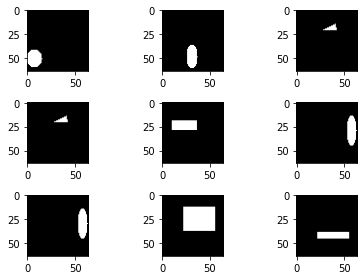

In [ ]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories = False,
        with_bboxes = False,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i * 2 +j])
plt.tight_layout()

## Train Classification Model

Create a data generator and compute a number of steps per epoch for training and validation.

In [ ]:

ds_train, train_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_train"), 
    output_schema = "C",
    num_detecting_objects=1,
    batch_size=128
)
ds_val, val_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_val"), 
    output_schema = "C",
    num_detecting_objects=1,
    batch_size=128
)

Create the classification model.

In [ ]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(128, activation='relu'),
	tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

2022-02-13 16:24:23.582365: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 60.06MiB (rounded to 62980096)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-13 16:24:23.582423: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-13 16:24:23.582449: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 13, Chunks in use: 13. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 193B client-requested in use in bin.
2022-02-13 16:24:23.582457: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-13 16:24:23.582463: I tensorflow/core/

ResourceExhaustedError: OOM when allocating tensor with shape[123008,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

Perform the model training.

In [ ]:
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=20,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    verbose=1
)

Epoch 1/20


2022-02-13 16:16:21.254011: E tensorflow/stream_executor/cuda/cuda_dnn.cc:361] Loaded runtime CuDNN library: 8.0.5 but source was compiled with: 8.1.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2022-02-13 16:16:21.254884: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sequential_1/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5394/2980847758.py", line 1, in <module>
      model.fit(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1/conv2d/Conv2D'
Detected at node 'sequential_1/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5394/2980847758.py", line 1, in <module>
      model.fit(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/mykola/Projects/squids/.venv/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1/conv2d/Conv2D'
2 root error(s) found.
  (0) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node sequential_1/conv2d/Conv2D}}]]
	 [[Func/categorical_crossentropy/cond/then/_0/input/_26/_44]]
  (1) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node sequential_1/conv2d/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_196953]

## Test Classification Model